In [1]:
import logging
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt

import theano_shim as shim
import sinn
import sinn.histories as histories
from sinn.histories import Spiketrain, Series
import sinn.iotools as io
import sinn.analyze as anlz
from sinn.analyze.heatmap import HeatMap
import sinn.optimize.gradient_descent as gd

import main
import fsgif_model as fsgif

import copy


np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

try:
    # Guard against defining multiple loggers
    logger
except NameError:
    rootlogger = logging.getLogger()
    rootlogger.setLevel(sinn.LoggingLevels.MONITOR)

    sthandler = logging.StreamHandler()
    sthandler.setLevel(logging.INFO)
    sthandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(sthandler)
    
    filehandler = logging.handlers.RotatingFileHandler(
        'fsgif.log', mode='w', maxBytes=5e5, backupCount=5)
    filehandler.setLevel(sinn.LoggingLevels.MONITOR)
    filehandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(filehandler)
    
    logger = logging.getLogger('fsgif')
    logger.setLevel(logging.INFO)

[monochrome_palette]: value was greater than 1 and was clipped.


In [2]:
import theano
import theano.tensor as T

In [3]:
source_datalen = 10 # Use 4 seconds of data
datalen = 8.0       # Amount of data to use for likelihood
burnin = 0.5        # Amount of data to discard from likelihood
mbatch_size = 100    # Batch size when computing likelihood / gradients

# Sample data trace

In [4]:
spikemodel = main.generate_spikes(datalen,
                                  filename='data/short_adap/fsgif_{}s_sin-input'
                                           .format(source_datalen))

2017-07-19 14:57:23,472 - root - INFO - Checking for precomputed data...
2017-07-19 14:57:24,388 - root - INFO - Precomputed data found. Skipping data generation


In [5]:
main.compute_spike_activity(max_len=burnin+datalen)

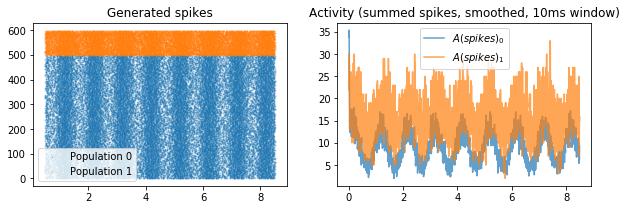

In [6]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
main.plot_raster(burnin, datalen)

plt.subplot(1,2,2)
main.plot_spike_activity()

In [ ]:
sinn.inputs.clear()

main.load_theano()

In [8]:
main.loaded['spike activity']['Ahist'].unlock()
main.loaded['spike activity']['Ihist'].unlock()
main.loaded['spike activity']['Ahist'].theano_reset()
main.loaded['spike activity']['Ihist'].theano_reset()
main.loaded['spike activity']['Ahist'].lock()
main.loaded['spike activity']['Ihist'].lock()
try:
    mfmodelT.theano_reset()
    mfmodelT.clear_unlocked_histories()
except NameError:
    pass
mfmodelT = main.derive_mf_model_from_spikes()

2017-07-18 23:42:51,988 - root - INFO - Producing Theano mean-field model.
2017-07-18 23:43:00,648 - root - INFO - Theano model complete.


In [9]:
mfmodelT.theano_reset()
mfmodelT.clear_unlocked_histories()

2017-07-18 23:43:06,854 - theano_shim - INFO - Clearing Theano updates


# Fits (gradient descent)

In [ ]:
basedir = "data/short_adap/fits/"

In [24]:
Key = namedtuple('Key', ('seed', 'batch', 'lr'))
keytuples = [(0, 100, 0.005),  (100, 100, 0.005),  (200, 100, 0.005),  (300, 100, 0.005),
             (0, 100, 0.0005), (100, 100, 0.0005), (200, 100, 0.0005), (300, 100, 0.0005),
             (0, 500, 0.005),  (100, 500, 0.005),  (200, 500, 0.005),  (300, 500, 0.005)]
keys = [Key(*t) for t in keytuples]

In [33]:
sgds = {key: gd.SGD(mfmodelT.loglikelihood, mfmodelT, 'adam', 
                    sgd_file = basedir + "fit_8s_{}lr_{:0>3}batch_{:0>3}seed.sir"
                                         .format(str(key.lr)[2:], key.batch, key.seed))
        for key in keys}

In [38]:
def plot_evol(lr, batch):
    plt.figure(figsize=(13, 3))
    
    plt.subplot(1,3,1)
    plt.title('$w_{EE}$ evolution')
    for key, sgd in sgds.items():
        if key.lr == lr and key.batch == batch:
            plt.plot(sgd.get_evol()['w'][:,0,0])
    plt.xlabel("epoch")
    plt.ylabel("$w_{EE}$")
    plt.axhline(0.176, color='orange')
    
    plt.subplot(1,3,2)
    plt.title('$τ_{m,I}$ evolution')
    for key, sgd in sgds.items():
        if key.lr == lr and key.batch == batch:
            plt.plot(10**(sgd.get_evol()['logτ_m'][:,1]))
    plt.xlabel('epoch')
    plt.ylabel('$τ_{m,I}$')
    plt.axhline(0.02, color='orange')
    
    plt.subplot(1,3,3)
    plt.title("log L evolution")
    for key, sgd in sgds.items():
        if key.lr == lr and key.batch == batch:
            plt.plot(sgd.get_evol()['logL'])
    plt.xlabel("epoch")
    plt.ylabel("log L")

## learning rate: 0.005, batch size: 100

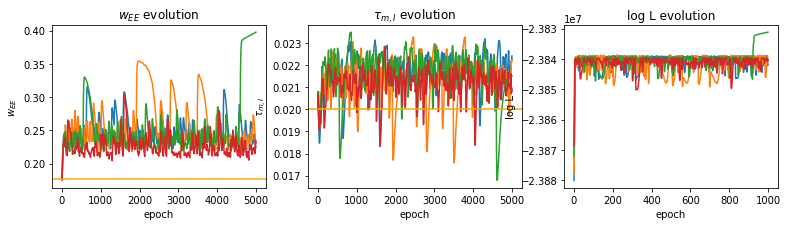

In [39]:
plot_evol(0.005, 100)

## learning rate: 0.0005, batch size: 100

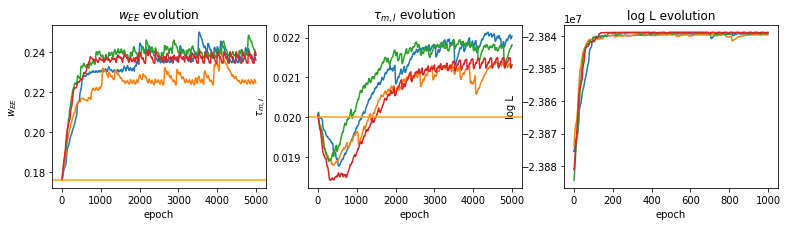

In [41]:
plot_evol(0.0005, 100)

## learning rate: 0.005, batch size: 500

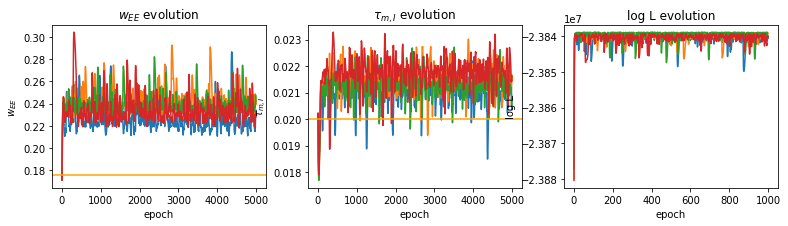

In [42]:
plot_evol(0.005, 500)